In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.preprocessing import StandardScaler
from itertools import permutations
import random
import warnings
warnings.simplefilter('ignore')

In [16]:
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [3]:
def fill_with_rand_from_col(data):
    df = data.copy()
    for name in list(df):
        all_not_na = df[df[name].notna()][name].to_numpy()
        all_values = set(np.arange(1,len(data)+1))
        to_fill_values = list(all_values - set(all_not_na))        
        to_fill = df[df[name].isna()][name].index
        df[name][to_fill] = np.random.permutation(to_fill_values)[:len(to_fill)]
    return df

Full = pd.read_csv('data.csv', delimiter =';', decimal=',')
weights = pd.read_csv('weights.csv', delimiter =';', decimal=',')

Full_fill = fill_with_rand_from_col(Full.drop(['Объект'], axis=1))
weights_fill= fill_with_rand_from_col(weights.drop(['Признаки'], axis=1))

prob_df = Full_fill.copy()

for name in list(prob_df)[:5]:
    density = scipy.stats.gaussian_kde(Full_fill[name])
    
    dx = Full_fill[name].std()/len(Full_fill)
    
    for i in range(len(prob_df)):
        x = Full_fill[name][i]
        p = 0
        if x - dx < 0:
            l = 0
        else:
            l = x - dx
        r = x + dx

        xs = np.linspace(l,r,100)
        y = density(xs)
        for j in range(len(xs)-1):
            p+=y[j] * (xs[j+1]-xs[j])
            
        prob_df.loc[i, name] = p

In [4]:
Full

,Объект,"Калорийность, кКал","Цена 100г, руб.",Белки,Жиры,Углеводы,Стрижов,Гребенькова,Михеев,Тихонов,Панченко,Панкратов,Харь,Савельев,Исламов,Волынцев,Христолюбов,Алсаханова
0,Устрицы,72.0,85.0,9.0,2.0,4.4,4.0,NaN,NaN,NaN,9,5.0,NaN,NaN,NaN,NaN,3.0,9
1,Арахиc соленый,640.0,69.0,25.0,52.0,17.0,2.0,6.0,4.0,NaN,7,4.0,3.0,3.0,NaN,4.0,6.0,3
2,"Молоко 2,5%",42.0,5.9,3.4,2.5,5.0,5.0,1.0,5.0,5.0,4,3.0,8.0,4.0,2.0,3.0,5.0,5
3,Макароны,371.0,34.0,3.6,0.4,20.0,7.0,7.0,2.0,3.0,2,8.0,4.0,6.0,3.0,5.0,NaN,6
4,Овсяное молоко 3.2%,250.0,8.0,1.0,3.2,6.5,NaN,2.0,7.0,2.0,6,7.0,5.0,5.0,7.0,NaN,7.0,7
5,Шоколад,545.0,100.0,5.0,33.0,56.5,3.0,4.0,1.0,NaN,5,NaN,1.0,1.0,6.0,6.0,1.0,2
6,"Сырок ""РОСТАГРОЭКСПОРТ"" творожный глазированны...",360.7,35.6,7.7,19.1,39.5,NaN,3.0,3.0,NaN,1,2.0,6.0,2.0,1.0,1.0,2.0,8
7,Кефир 3.2%,57.0,5.9,3.0,3.2,4.0,6.0,5.0,8.0,4.0,8,1.0,7.0,7.0,4.0,7.0,NaN,1
8,Гречневая крупа,334.0,4.0,12.0,2.0,67.0,1.0,8.0,6.0,1.0,3,6.0,2.0,8.0,5.0,2.0,4.0,4


In [5]:
from scipy.stats import ks_2samp
from scipy.stats import entropy

In [6]:
def getInvCount(arr):
    n = len(arr)
    inv_count = 0
    for i in range(n):
        for j in range(i + 1, n):
            if (arr[i] > arr[j]):
                inv_count += 1
    return inv_count

In [7]:
A = prob_df.to_numpy()
w0 = weights_fill.mean(axis = 1).to_numpy()/weights_fill.std(axis = 1).to_numpy()
q_median = Full_fill[list(Full_fill)[5:]].mean(axis = 1).to_numpy()

Q0 = pd.DataFrame()
Q0['Weight'] = q_median
Q0 = Q0.sort_values('Weight',ascending=True)
Q0['ind'] = np.arange(len(Full))+1
q0 = Q0.sort_index(inplace=False)['ind'].to_numpy()
q0_temp = q0.copy()

A = (A - A.mean(axis = 0))/A.std(axis = 0)
q0 = (q0 - np.mean(q0))/np.std(q0)

g = 1
I = np.diag(np.ones(A.shape[1]))
w_g = np.linalg.inv(((A.T@A) - g*I)) @ (A.T@q0 + g*w0)
q_new = A @ w_g.T

In [8]:
Rating = pd.DataFrame()
Rating['Weight'] = q_new
Rating = Rating.sort_values('Weight',ascending=True)
Rating['ind'] = np.arange(len(Full))+1
q_hat = Rating.sort_index(inplace=False)['ind'].to_numpy()

In [9]:
q = [[9,4,5,6,7,1,2,8,3], [9,5,4,6,7,3,1,8,2], [7,3,5,6,9,2,1,8,4], q0_temp]
inds = ['Григорьев Алексей','Панченко Святослав', 'Надежда Алсаханова','Среднее']

In [10]:
products =[
    'Устрицы',
    'Арахиc',
    'Молоко 2,5%',
    'Макароны',
    'Овсяное молоко 3.2%',
    'Шоколад',
    'Сырок творожный',
    'Кефир 3.2%',
    'Гречневая крупа']

In [11]:
q_hat

array([9, 3, 5, 8, 7, 2, 1, 6, 4])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


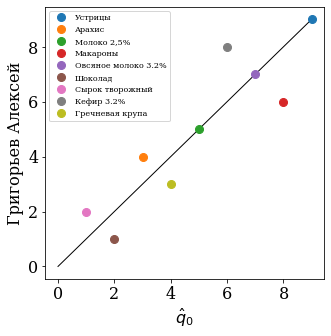

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


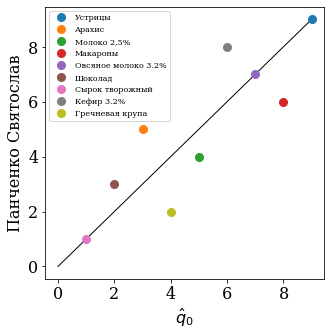

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


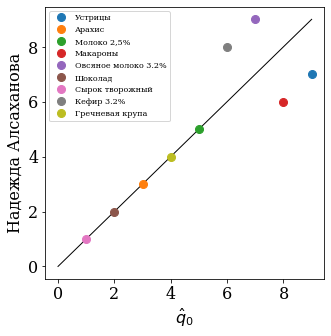

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


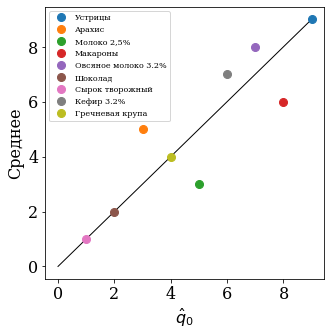

In [17]:

for i in range(len(q)):
    plt.plot([0,9], [0,9], 'k-', linewidth = 1)
    for j, product in enumerate(products):
        plt.plot(q_hat[j], q[i][j], 'o',label = product)
    
    
    plt.ylabel(inds[i], size=16)
    plt.xlabel('$\hat{q}_0$', size=16)
    plt.legend()
    
    plt.savefig('../doc/fig/inds'+str(i)+'.eps',
                format='eps',
                dpi=600,
                bbox_inches='tight')
    
    plt.savefig('../slides/results/inds'+str(i)+'.eps',
                format='eps',
                dpi=600,
                bbox_inches='tight')
    
    plt.show()

In [ ]:
density_not_na = scipy.stats.gaussian_kde(Full.iloc[:,9].dropna().to_numpy(dtype = 'float'))
xs = np.linspace(-5,15,100)
dx = density_not_na(xs)
plt.plot(dx)

density_not_na = scipy.stats.gaussian_kde(Full_fill.iloc[:,9].dropna().to_numpy(dtype = 'float'),)
ys = np.linspace(-5,15,100)
dy = density_not_na(ys)
plt.plot(dy)

Ans = []
ql = []
for i in range(3,10):
    current = np.arange(1,i)
    current = list(permutations(current))[random.randint(0,i-1)]
    full = np.arange(1,10)
    for j in range(i,9):
        full[j] = random.choice(current)
    
    xs = np.linspace(-5,25,100)
    
    dens = scipy.stats.gaussian_kde(full)
    dfull = dens(xs)
    
    dens = scipy.stats.gaussian_kde(current)
    dcurrent = dens(xs)
    Ans.append(list(ks_2samp(full, current)))
    ql.append(entropy(pk=dfull, qk=dcurrent))
    plt.plot(xs, dfull,label = 'Известные')
    plt.plot(xs, dcurrent, label = 'Заполненые')
    plt.legend()
    plt.savefig('../slides/results/dens'+str(i)+'.eps',
            format='eps',
            dpi=600,
            bbox_inches='tight')
    plt.show()
    print(getInvCount(full),getInvCount(current))